In [1]:
import geopandas as gpd
import pandas as pd
import pickle
from tools.tools import plot_current_state_of_graph

In [ ]:
path = "/home/datasets4/stein/rivers/saves"

In [173]:
meta = pd.read_csv("saves/saxony_flood_meta_data.csv", index_col=0)

In [174]:
data = pd.read_csv("saves/saxony_flood_processed.csv", index_col=0)

In [175]:
G = pickle.load(open("saves/crawl_saves/station_G.p", "rb"))

In [176]:
meta.rename(index={
    501060:5010600,
    501110:5011100,
    501261:5012601
    }, inplace=True)
# ID slightly off as these are from another data source.

In [177]:
data.rename(columns={
    "501060_s":"5010600_s",
    "501110_s":"5011100_s",
    "501261_s":"5012601_s"
    }, inplace=True)
# ID slightly off as these are from another data source.

In [178]:
# This file is only created later. Rearange the ordering here.
meta_eg = pd.read_csv("saves/rivers_meta_east_germany.csv", index_col=0)

In [179]:
meta.loc[[x for x in meta.index if "id_" + str(x) not in meta_eg["original_id"].values]]

,R,X,Y,D,H,QD,QH,QX,QY,QR
ID,,,,,,,,,,


In [180]:
relevant = meta_eg.loc[meta_eg["original_id"].isin("id_" + meta.index.astype(str))]

In [181]:
# outside
relevant.drop(index=[1150,697], inplace=True)

/tmp/ipykernel_3053552/1582659419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant.drop(index=[1150,697], inplace=True)


In [183]:
data = data[[x[3:] + "_s" for x in relevant.original_id]]

In [184]:
flood_graph = G.subgraph(relevant.index)

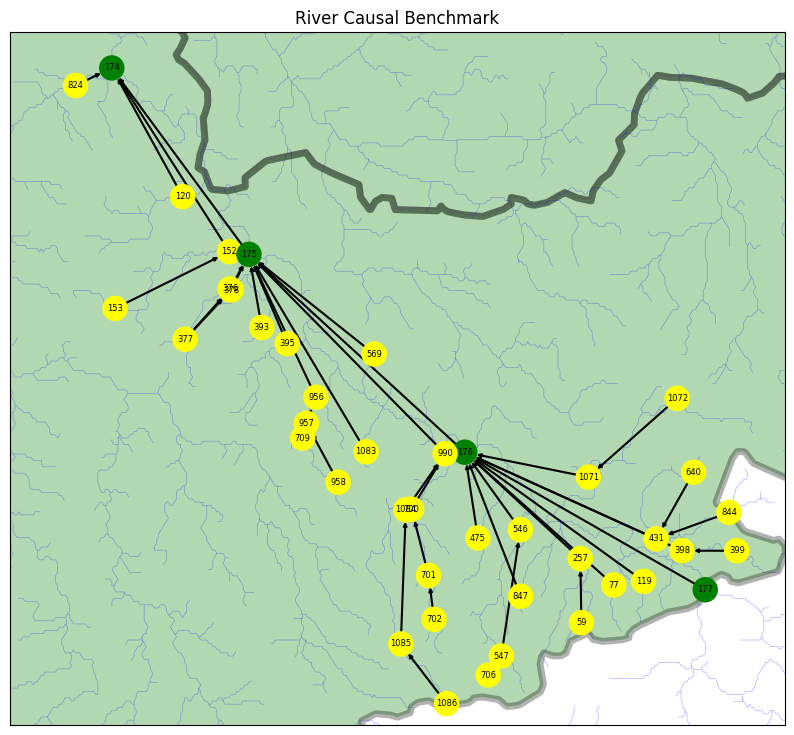

In [74]:
# Full Graph
plot_current_state_of_graph(
    flood_graph,
    dpi=500,
    lim=(50.7, 51.6),
    limx=(12.8, 14.4),
    node_size=300,
    save=0,
    river_map=True,
    hardcode_colors= ["green" if (relevant.loc[x, "R"] == "Elbe") else "yellow" for x in flood_graph.nodes],
    ger_map=True,
    width=1.5,
    arrowsize=5,
    fs=(10, 10),
    font_size=6,
)

In [185]:
import copy
pickle.dump(flood_graph.copy(),open('saves/flood_G.p', 'wb'))

In [186]:
rename = []
for y in  [x[:-2]  for x in data.columns]:
    rename.append(meta_eg[meta_eg["original_id"].str.contains(y)].index[0])

In [187]:
data.columns = rename

In [189]:
import numpy as np

In [192]:
np.all(relevant.index == sorted(list(flood_graph.nodes))),np.all(data.columns == sorted(list(flood_graph.nodes)))

(True, True)

In [196]:
relevant.to_csv("saves/rivers_meta_flood.csv")
data.to_csv("saves/rivers_flood.csv")

### Prep a map for this as well i guess

In [84]:
# We have data for all states if this will become necessary in the future.
country_index,naming = [12], "saxony"


<Axes: >

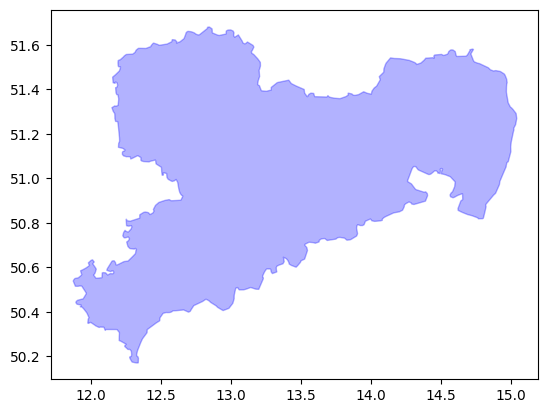

In [85]:
fp =  "visualization/geomaps/vg2500_bld.shp"
map_df = gpd.read_file(fp)
map_df = map_df.loc[country_index]
map_df.plot(color="blue", alpha=0.3, linewidth=1, edgecolor='blue')

In [86]:
# This loads a bit
fp =  "visualization/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu.shp"
r_df = gpd.read_file(fp)
#r_df.plot(color="blue", alpha=0.3, linewidth=1, edgecolor='blue')

In [87]:
# Different filter to check all relevant rivers that match with the state template.
crossings = []
for x in map_df.index:
    crossings.append(map_df.loc[x, "geometry"].boundary.crosses(r_df.loc[:, "geometry"]))
crossings = r_df[pd.concat(crossings,axis=1).any(axis=1)]

In [88]:
contains = []
for x in map_df.index:
    contains.append(map_df.loc[x, "geometry"].contains(r_df.loc[:, "geometry"]))
contains = r_df[pd.concat(contains,axis=1).any(axis=1)]

In [89]:
intersect = []
for x in map_df.index:
    intersect.append(map_df.loc[x, "geometry"].contains(r_df.loc[:, "geometry"]))
intersect = r_df[pd.concat(intersect,axis=1).any(axis=1)]

<Axes: >

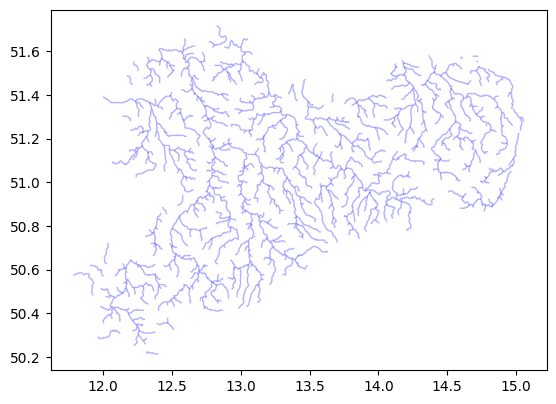

In [90]:
pd.concat([crossings, contains,intersect]).drop_duplicates(subset = "HYRIV_ID").plot(alpha=0.3, linewidth=1, edgecolor='blue')

In [91]:
pd.concat([crossings, contains,intersect]).drop_duplicates(subset = "HYRIV_ID").to_file("visualization/river_" + naming + "_map.shp")

In [92]:
map_df.to_file("visualization/" + naming + "_map.shp")